<a href="https://colab.research.google.com/github/ethancarter7/nfl-predictions/blob/main/nflpredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# First, restart runtime, then run this cell
import sys

if 'nfl_data_py' not in sys.modules:
    print("Installing nfl-data-py...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nfl-data-py", "--quiet"])
    print("Installation complete!")


import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

print("All packages imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Installing nfl-data-py...
✅ Installation complete!
✅ All packages imported successfully!
NumPy version: 1.26.4
Pandas version: 1.5.3


In [ ]:
print("\n Loading NFL data...")
years = [2019,2020,2021,2022,2023,2024] #the years to analyze (for now)

print("Loading schedule/game results")
schedule = nfl.import_schedules(years)

print("Loading weekly team stats...")
weekly_stats = nfl.import_weekly_data(years, downcast=True)

print("Loading play-by-play data (this may take a while)...")
pbp = nfl.import_pbp_data([2024], downcast=True)

print(f"Data loaded successfully!")
print(f"Schedule shape: {schedule.shape}")
print(f"Weekly stats shape: {weekly_stats.shape}")
print(f"Play-by-play shape: {pbp.shape}")




 Loading NFL data...
Loading schedule/game results
Loading weekly team stats...
Downcasting floats.
Loading play-by-play data (this may take a while)...
2024 done.
Downcasting floats.
✅ Data loaded successfully!
Schedule shape: (1675, 46)
Weekly stats shape: (33287, 53)
Play-by-play shape: (49492, 397)


# New Section

In [ ]:
print("\n=== SCHEDULE DATA ===")
print("Columns:", list(schedule.columns))
print("\nFirst few games:")
print(schedule[['game_id', 'season', 'week', 'home_team', 'away_team', 'home_score', 'away_score','away_qb_name', 'home_qb_name']].head())



=== SCHEDULE DATA ===
Columns: ['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday', 'gametime', 'away_team', 'away_score', 'home_team', 'home_score', 'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest', 'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds', 'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'roof', 'surface', 'temp', 'wind', 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'stadium']

First few games:
              game_id  season  week home_team away_team  home_score  \
5316   2019_01_GB_CHI    2019     1       CHI        GB         3.0   
5317   2019_01_LA_CAR    2019     1       CAR        LA        27.0   
5318  2019_01_TEN_CLE    2019     1       CLE       TEN        13.0   
5319   2019_01_KC_JAX    2019     1       JAX        KC        26.0   
5320  2019_01_BAL_MIA  

In [ ]:
print("\n=== WEEKLY STATS DATA ===")
print("Columns:", list(weekly_stats.columns)[:20], "...Only showing first 20")
print(f"Unique teams: {weekly_stats['recent_team'].nunique()}")
print(f"Unique players: {weekly_stats['player_id'].nunique()}")



=== WEEKLY STATS DATA ===
Columns: ['player_id', 'player_name', 'player_display_name', 'position', 'position_group', 'headshot_url', 'recent_team', 'season', 'week', 'season_type', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost'] ...Only showing first 20
Unique teams: 32
Unique players: 1381


In [ ]:
print("\n=== GAME OUTCOMES ===")
print("Games with results:", schedule['home_score'].notna().sum())
print("Total games:", len(schedule))


=== GAME OUTCOMES ===
Games with results: 1675
Total games: 1675



Preprocessing data for ML model...
------------------------------------
Here are some basic stats:
Processed 1675 completed games
Home team win rate: 0.536
Average home score: 23.7
Average away score: 22.1
Home field advantage: 1.6 points


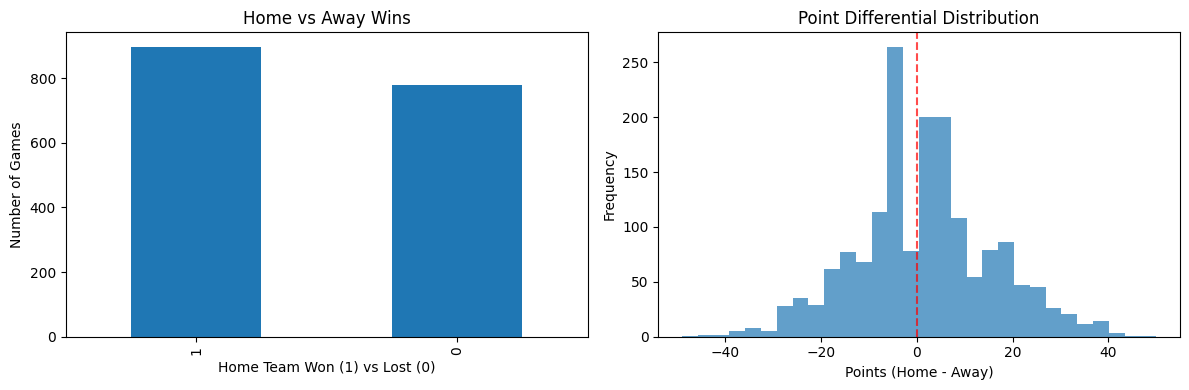

In [ ]:
# Data preprocessing
print("\nPreprocessing data for ML model...")
print("------------------------------------")
completed_games = schedule[schedule['home_score'].notna()].copy()

# Create target variable (1 if home team wins, 0 if away team wins)
completed_games['home_team_won'] = (completed_games['home_score'] > completed_games['away_score']).astype(int)

# point differential
completed_games['point_differential'] = completed_games['home_score'] - completed_games['away_score']

print("Here are some basic stats:")
print(f"Processed {len(completed_games)} completed games")
print(f"Home team win rate: {completed_games['home_team_won'].mean():.3f}")
print(f"Average home score: {completed_games['home_score'].mean():.1f}")
print(f"Average away score: {completed_games['away_score'].mean():.1f}")
print(f"Home field advantage: {(completed_games['home_score'] - completed_games['away_score']).mean():.1f} points")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
completed_games['home_team_won'].value_counts().plot(kind='bar')
plt.title('Home vs Away Wins')
plt.xlabel('Home Team Won (1) vs Lost (0)')
plt.ylabel('Number of Games')

plt.subplot(1, 2, 2)
plt.hist(completed_games['point_differential'], bins=30, alpha=0.7)
plt.title('Point Differential Distribution')
plt.xlabel('Points (Home - Away)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering

print("\n Calculating team performance metrics...")

def calculate_team_stats(weekly_data, years):
    """Calculate aggregated team statistics for each season"""

    team_stats = []

    for year in years:
        year_data = weekly_data[weekly_data['season'] == year]

        # Group by team and calculate season averages
        team_season_stats = year_data.groupby('recent_team').agg({
            # Offensive stats
            'passing_yards': 'mean',
            'rushing_yards': 'mean',
            'receiving_yards': 'mean',
            'passing_tds': 'sum',
            'rushing_tds': 'sum',
            'receiving_tds': 'sum',
            'fantasy_points': 'mean',

            # Efficiency metrics (if available)
            'targets': 'sum',
            'receptions': 'sum',
            'carries': 'sum',
        }).reset_index()

        team_season_stats['season'] = year #adding in the current season as column

        # Calculate derived metrics
        team_season_stats['total_yards_per_game'] = (
            team_season_stats['passing_yards'] + team_season_stats['rushing_yards']
        )
        team_season_stats['total_tds'] = (
            team_season_stats['passing_tds'] + team_season_stats['rushing_tds'] + team_season_stats['receiving_tds']
        )

        # Catch rate (avoiding division by zero)
        team_season_stats['catch_rate'] = np.where(
            team_season_stats['targets'] > 0,
            team_season_stats['receptions'] / team_season_stats['targets'],
            0
        )

        # average yards per carry
        team_season_stats['yards_per_carry'] = np.where(
            team_season_stats['carries'] > 0,
            team_season_stats['rushing_yards'] / team_season_stats['carries'],
            0
        )

        team_stats.append(team_season_stats)

    return pd.concat(team_stats, ignore_index=True)

# Calculate team statistics
team_performance = calculate_team_stats(weekly_stats, years)
print(f" Calculated stats for {team_performance['recent_team'].nunique()} teams across {len(years)} seasons")




 Calculating team performance metrics...
 Calculated stats for 32 teams across 6 seasons


In [ ]:
# Calculate Team Win/Loss Records
print("\n Calculating team records...")

def calculate_team_records(schedule_data):
    """Calculate win/loss records for each team by season"""

    records = []

    # Process completed games only
    completed = schedule_data[schedule_data['home_score'].notna()].copy()

    for _, game in completed.iterrows(): #iterating through each row
        season = game['season']
        home_team = game['home_team']
        away_team = game['away_team']
        home_won = game['home_score'] > game['away_score']

        # Record for home team
        records.append({
            'team': home_team,
            'season': season,
            'game_id': game['game_id'],
            'won': 1 if home_won else 0,
            'points_for': game['home_score'],
            'points_against': game['away_score'],
            'is_home': 1
        })

        # Record for away team
        records.append({
            'team': away_team,
            'season': season,
            'game_id': game['game_id'],
            'won': 1 if not home_won else 0,
            'points_for': game['away_score'],
            'points_against': game['home_score'],
            'is_home': 0
        })

    records_df = pd.DataFrame(records)

    # Calculate season totals for each team
    team_records = records_df.groupby(['team', 'season']).agg({
        'won': 'sum',
        'game_id': 'count',  # total games
        'points_for': 'mean',
        'points_against': 'mean',
        'is_home': 'sum'  # home games played
    }).reset_index()

    # Rename columns for clarity
    team_records.columns = ['team', 'season', 'wins', 'games_played', 'avg_points_for', 'avg_points_against', 'home_games']

    # Calculate derived metrics
    team_records['win_pct'] = team_records['wins'] / team_records['games_played']
    team_records['point_differential'] = team_records['avg_points_for'] - team_records['avg_points_against']

    return team_records

team_records = calculate_team_records(schedule)
print(f" Calculated records for {team_records['team'].nunique()} teams")
print(team_records)
# Step Create Recent Performance Features
print("\n Creating recent performance features...")




 Calculating team records...
 Calculated records for 33 teams
    team  season  wins  games_played  avg_points_for  avg_points_against  \
0    ARI    2019     5            16       22.562500           27.625000   
1    ARI    2020     8            16       25.625000           22.937500   
2    ARI    2021    11            18       25.555556           22.222222   
3    ARI    2022     4            17       20.000000           26.411765   
4    ARI    2023     4            17       19.411765           26.764706   
..   ...     ...   ...           ...             ...                 ...   
187  WAS    2020     7            17       21.058824           21.176471   
188  WAS    2021     7            17       19.705882           25.529412   
189  WAS    2022     9            17       18.882353           20.176471   
190  WAS    2023     4            17       19.352941           30.470588   
191  WAS    2024    14            20       28.800000           24.850000   

     home_games   win_pc

In [ ]:
#Create Recent Performance Features
print("\n Creating recent performance features...")
def calculate_recent_performamce(schedule_data, n_games=5):
    """Calculate recent form (last N games) for each team"""

    completed = schedule_data[schedule_data['home_score'].notna()].copy()
    completed = completed.sort_values(['season', 'week'])

    recent_performance = []

    for team in completed['home_team'].unique():
        team_games = []

        # Get all games for this team
        home_games = completed[completed['home_team'] == team][['game_id', 'season', 'week', 'home_score', 'away_score']].copy()
        home_games['team_score'] = home_games['home_score']
        home_games['opp_score'] = home_games['away_score']

        away_games = completed[completed['away_team'] == team][['game_id', 'season', 'week', 'home_score', 'away_score']].copy()
        away_games['team_score'] = away_games['away_score']
        away_games['opp_score'] = away_games['home_score']

        all_games = pd.concat([home_games, away_games])[['game_id', 'season', 'week', 'team_score', 'opp_score']]
        all_games = all_games.sort_values(['season', 'week'])
        all_games['team'] = team
        all_games['won'] = (all_games['team_score'] > all_games['opp_score']).astype(int)

        # Calculate rolling metrics
        all_games['recent_wins'] = all_games['won'].rolling(window=n_games, min_periods=1).sum()
        all_games['recent_games'] = all_games['won'].rolling(window=n_games, min_periods=1).count()
        all_games['recent_win_pct'] = all_games['recent_wins'] / all_games['recent_games']
        all_games['recent_ppg'] = all_games['team_score'].rolling(window=n_games, min_periods=1).mean()
        all_games['recent_ppg_allowed'] = all_games['opp_score'].rolling(window=n_games, min_periods=1).mean()

        recent_performance.append(all_games)

    return pd.concat(recent_performance, ignore_index=True)

recent_performance = calculate_recent_performamce(schedule)
print(f" Calculated recent form for {recent_performance['team'].nunique()} teams")





 Creating recent performance features...
 Calculated recent form for 33 teams


In [ ]:
# Merge Features for Game Prediction
print("\n Merging features for game-level predictions...")

def create_game_features(schedule_data, team_records, team_performance, recent_performance):
    """Create features for each game by merging team-level data"""

    # Start with completed games
    games = schedule_data[schedule_data['home_score'].notna()].copy()

    # Merge home team features
    games = games.merge(
        team_records.rename(columns={'team': 'home_team', 'win_pct': 'home_win_pct',
                                   'point_differential': 'home_point_diff'}),
        on=['home_team', 'season'],
        how='left'
    )

    # Merge away team features
    games = games.merge(
        team_records.rename(columns={'team': 'away_team', 'win_pct': 'away_win_pct',
                                   'point_differential': 'away_point_diff'}),
        on=['away_team', 'season'],
        how='left'
    )

    # Create comparative features
    games['win_pct_diff'] = games['home_win_pct'] - games['away_win_pct']
    games['point_diff_advantage'] = games['home_point_diff'] - games['away_point_diff']

    # Add recent performance (last game before current game)
    games = games.merge(
        recent_performance[['team', 'season', 'week', 'recent_win_pct', 'recent_ppg']].rename(
            columns={'team': 'home_team', 'recent_win_pct': 'home_recent_win_pct', 'recent_ppg': 'home_recent_ppg'}
        ),
        on=['home_team', 'season', 'week'],
        how='left'
    )

    games = games.merge(
        recent_performance[['team', 'season', 'week', 'recent_win_pct', 'recent_ppg']].rename(
            columns={'team': 'away_team', 'recent_win_pct': 'away_recent_win_pct', 'recent_ppg': 'away_recent_ppg'}
        ),
        on=['away_team', 'season', 'week'],
        how='left'
    )

    return games

# Create the final feature set
game_features = create_game_features(completed_games, team_records, team_performance, recent_performance)

print(f" Created features for {len(game_features)} games")
print(f"Columns: {list(game_features.columns)}")





 Merging features for game-level predictions...
 Created features for 1675 games
Columns: ['game_id', 'season', 'game_type', 'week', 'gameday', 'weekday', 'gametime', 'away_team', 'away_score', 'home_team', 'home_score', 'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest', 'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds', 'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'roof', 'surface', 'temp', 'wind', 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'stadium', 'home_team_won', 'point_differential', 'wins_x', 'games_played_x', 'avg_points_for_x', 'avg_points_against_x', 'home_games_x', 'home_win_pct', 'home_point_diff', 'wins_y', 'games_played_y', 'avg_points_for_y', 'avg_points_against_y', 'home_games_y', 'away_win_pct', 'away_point_diff', 'win_pct_diff', 'point_diff_advantage', 'home_recent


 Preparing features for machine learning...
Feature matrix shape: (1675, 10)
Target distribution: {1: 897, 0: 778}

 Feature correlations with target:
home_recent_win_pct: 0.545
win_pct_diff: 0.509
point_diff_advantage: 0.449
home_win_pct: 0.371
home_recent_ppg: 0.326
home_point_diff: 0.326
away_point_diff: -0.323
away_recent_ppg: -0.335
away_win_pct: -0.359
away_recent_win_pct: -0.509


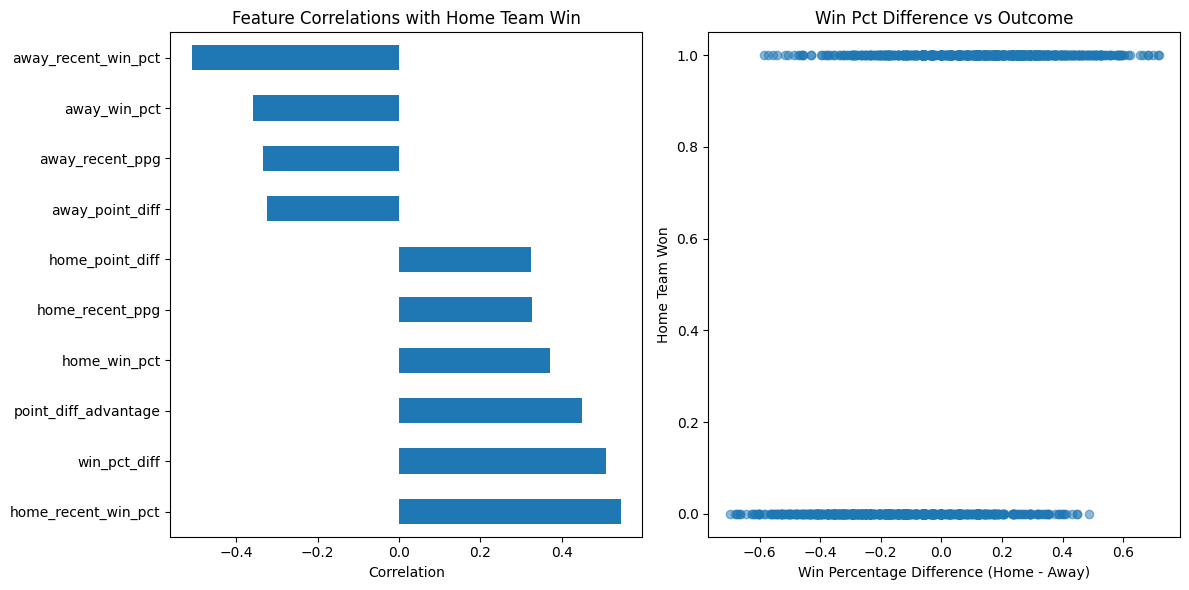


 Feature engineering complete!

 Next up: Build and train the ML model
Ready to predict with 10 features across 1675 games
Model trained successfully!
Test Accuracy: 0.821 (82.1%)
Cross-validation accuracy: 0.799 ± 0.024

Classification Report:
                precision    recall  f1-score   support

Away Team Wins       0.82      0.79      0.81       156
Home Team Wins       0.83      0.84      0.83       179

      accuracy                           0.82       335
     macro avg       0.82      0.82      0.82       335
  weighted avg       0.82      0.82      0.82       335



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#  Prepare Features for ML Model
print("\n Preparing features for machine learning...")


# Select key features for prediction
feature_columns = [
    'home_win_pct', 'away_win_pct', 'win_pct_diff',
    'home_point_diff', 'away_point_diff', 'point_diff_advantage',
    'home_recent_win_pct', 'away_recent_win_pct',
    'home_recent_ppg', 'away_recent_ppg'
]

# Create feature matrix (X) and target (y)
X = game_features[feature_columns].fillna(0)  # Fill NaN with 0
y = game_features['home_team_won']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Display feature correlation
print("\n Feature correlations with target:")
correlations = X.corrwith(y).sort_values(ascending=False)
for feature, corr in correlations.items():
    print(f"{feature}: {corr:.3f}")


# Visualize feature importance
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
correlations.plot(kind='barh')
plt.title('Feature Correlations with Home Team Win')
plt.xlabel('Correlation')

plt.subplot(1, 2, 2)
plt.scatter(X['win_pct_diff'], y, alpha=0.5)
plt.xlabel('Win Percentage Difference (Home - Away)')
plt.ylabel('Home Team Won')
plt.title('Win Pct Difference vs Outcome')

plt.tight_layout()
plt.show()

print("\n Feature engineering complete!")
print("\n Next up: Build and train the ML model")
print(f"Ready to predict with {len(feature_columns)} features across {len(X)} games")

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)
print("Model trained successfully!")

# Testing data
y_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# prediction probabilities
y_pred_proba = rf_model.predict_proba(X_test)[:, 1] # Probability of home team winning (1)

print(f"Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")


cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['Away Team Wins', 'Home Team Wins']))






🎯 Confusion Matrix:
True Negatives (Away wins predicted correctly): 124
False Positives (Home wins predicted, away won): 32
False Negatives (Away wins predicted, home won): 28
True Positives (Home wins predicted correctly): 151

🔍 Feature Importance Analysis...
Top Features for Predicting Game Outcomes:
home_recent_win_pct: 0.227
away_recent_win_pct: 0.185
win_pct_diff: 0.155
point_diff_advantage: 0.093
away_recent_ppg: 0.077
home_recent_ppg: 0.063
home_point_diff: 0.053
away_point_diff: 0.051
away_win_pct: 0.049
home_win_pct: 0.048

📊 Creating visualizations...


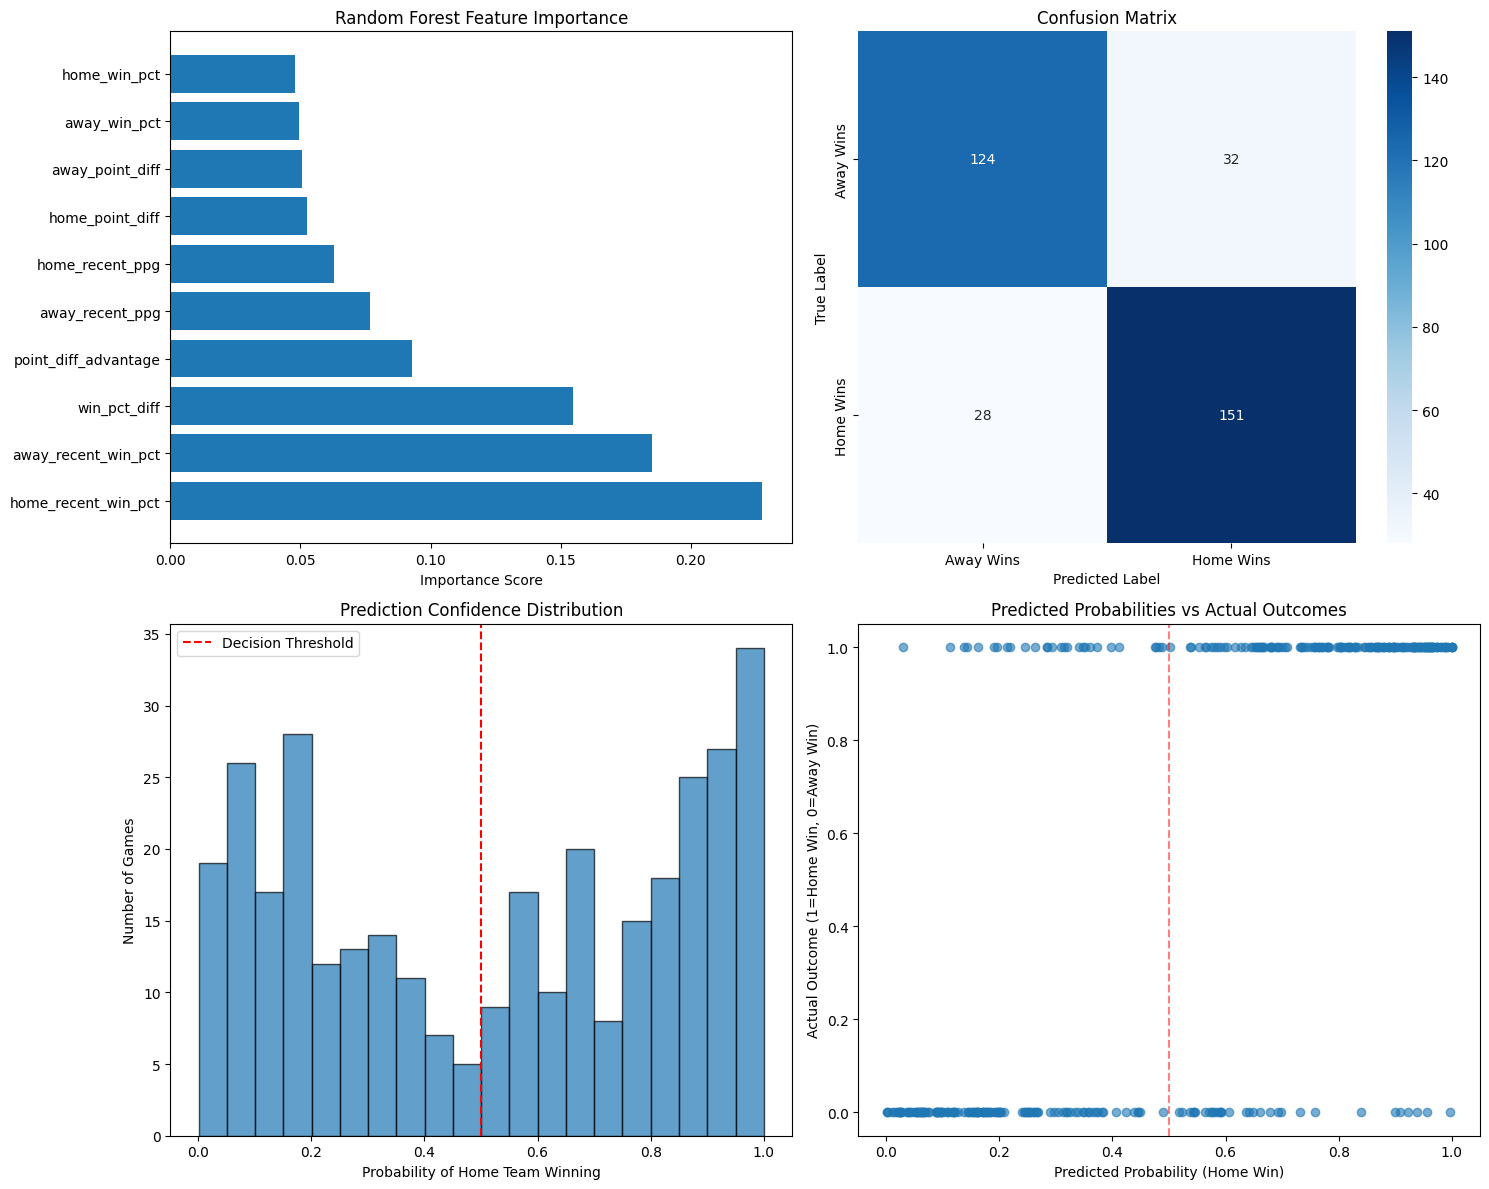


🏆 RANDOM FOREST MODEL SUMMARY
✅ Test Accuracy: 82.1%
✅ Cross-Val Accuracy: 79.9% ± 2.4%
🎯 Total Games Analyzed: 1675
🏠 Baseline (Always Predict Home): 53.6%
📈 Model Improvement: +28.5 percentage points

🔝 Most Important Features:
1. home_recent_win_pct: 0.227
2. away_recent_win_pct: 0.185
3. win_pct_diff: 0.155


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"True Negatives (Away wins predicted correctly): {cm[0,0]}")
print(f"False Positives (Home wins predicted, away won): {cm[0,1]}")
print(f"False Negatives (Away wins predicted, home won): {cm[1,0]}")
print(f"True Positives (Home wins predicted correctly): {cm[1,1]}")

print("\n🔍 Feature Importance Analysis...")

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top Features for Predicting Game Outcomes:")
for i, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

# Step 3.7: Visualizations
print("\n Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance Plot
axes[0,0].barh(feature_importance['feature'], feature_importance['importance'])
axes[0,0].set_title('Random Forest Feature Importance')
axes[0,0].set_xlabel('Importance Score')

# 2. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Away Wins', 'Home Wins'],
            yticklabels=['Away Wins', 'Home Wins'],
            ax=axes[0,1])
axes[0,1].set_title('Confusion Matrix')
axes[0,1].set_ylabel('True Label')
axes[0,1].set_xlabel('Predicted Label')

# 3. Prediction Confidence Distribution
axes[1,0].hist(y_pred_proba, bins=20, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Prediction Confidence Distribution')
axes[1,0].set_xlabel('Probability of Home Team Winning')
axes[1,0].set_ylabel('Number of Games')
axes[1,0].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
axes[1,0].legend()

# 4. Actual vs Predicted Scatter
axes[1,1].scatter(y_pred_proba, y_test, alpha=0.6)
axes[1,1].set_xlabel('Predicted Probability (Home Win)')
axes[1,1].set_ylabel('Actual Outcome (1=Home Win, 0=Away Win)')
axes[1,1].set_title('Predicted Probabilities vs Actual Outcomes')
axes[1,1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Step 3.8: Model Summary
print(f"\n RANDOM FOREST MODEL SUMMARY")
print(f"=" * 50)
print(f" Test Accuracy: {test_accuracy:.1%}")
print(f" Cross-Val Accuracy: {cv_scores.mean():.1%} ± {cv_scores.std():.1%}")
print(f" Total Games Analyzed: {len(X)}")
print(f" Baseline (Always Predict Home): {y.mean():.1%}")
print(f" Model Improvement: +{(test_accuracy - y.mean())*100:.1f} percentage points")

print(f"\n Most Important Features:")
for i in range(min(3, len(feature_importance))):
    row = feature_importance.iloc[i]
    print(f"{i+1}. {row['feature']}: {row['importance']:.3f}")

In [ ]:
try:
    # Load 2025 schedule (including future games)
    schedule_2025 = nfl.import_schedules([2025])
    print(f" Loaded {len(schedule_2025)} games for 2025 season")

    # Load current 2025 weekly stats
    weekly_stats_2025 = nfl.import_weekly_data([2025], downcast=True)
    print(f" Loaded 2025 weekly stats")

    # Also load recent years for comparison (2022-2024)
    recent_years = [2022, 2023, 2024]
    historical_weekly = nfl.import_weekly_data(recent_years, downcast=True)
    combined_weekly = pd.concat([historical_weekly, weekly_stats_2025], ignore_index=True)

except Exception as e:
    print(f"  Error loading 2025 weekly data: {e}")
    print("Using 2024 weekly data for team stats...")
    # Keep the 2025 schedule, just use 2024 weekly stats
    combined_weekly = nfl.import_weekly_data([2022, 2023, 2024], downcast=True)

✅ Loaded 272 games for 2025 season
⚠️  Error loading 2025 weekly data: HTTP Error 404: Not Found
Using 2024 weekly data for team stats...
Downcasting floats.


In [ ]:
# Identify Future Games
print("\n Identifying upcoming games...")

# Find games without scores (future games)
future_games = schedule_2025[schedule_2025['home_score'].isna()].copy()
completed_games_2025 = schedule_2025[schedule_2025['home_score'].notna()].copy()

print(f"📊 2025 Season Status:")
print(f"   Completed games: {len(completed_games_2025)}")
print(f"   Future games: {len(future_games)}")

if len(future_games) == 0:
    print("🎯 All 2025 games completed! Using recent completed games for demonstration...")
    # Use most recent completed games for demo
    future_games = completed_games_2025.tail(10).copy()
    # Remove scores to simulate future games
    future_games['home_score'] = None
    future_games['away_score'] = None


print("\n Calculating current team performance...")

def calculate_current_team_stats(weekly_data, schedule_data, current_year=2025):
    """Calculate current season stats for teams"""

    # Get current year data
    current_weekly = weekly_data[weekly_data['season'] == current_year]

    if len(current_weekly) == 0:
        print(" No current season weekly data, using most recent season...")
        current_weekly = weekly_data[weekly_data['season'] == weekly_data['season'].max()]

    # Calculate team stats
    team_stats = current_weekly.groupby('recent_team').agg({
        'passing_yards': 'mean',
        'rushing_yards': 'mean',
        'fantasy_points': 'mean'
    }).reset_index()

    # Calculate team records from completed games
    completed = schedule_data[schedule_data['home_score'].notna()].copy()

    if len(completed) == 0:
        print(" No completed games found, creating placeholder records...")
        # Create placeholder records
        teams = schedule_data['home_team'].unique()
        team_records = pd.DataFrame({
            'team': teams,
            'season': current_year,
            'wins': 8,  # Placeholder
            'games_played': 16,
            'avg_points_for': 22,
            'avg_points_against': 22,
            'win_pct': 0.5,
            'point_differential': 0
        })
    else:
        # Calculate actual records
        records = []
        for _, game in completed.iterrows():
            home_won = game['home_score'] > game['away_score']

            records.append({
                'team': game['home_team'],
                'season': current_year,
                'won': 1 if home_won else 0,
                'points_for': game['home_score'],
                'points_against': game['away_score']
            })

            records.append({
                'team': game['away_team'],
                'season': current_year,
                'won': 1 if not home_won else 0,
                'points_for': game['away_score'],
                'points_against': game['home_score']
            })

        records_df = pd.DataFrame(records)
        team_records = records_df.groupby(['team', 'season']).agg({
            'won': 'sum',
            'points_for': ['count', 'mean'],
            'points_against': 'mean'
        }).reset_index()

        # Flatten column names
        team_records.columns = ['team', 'season', 'wins', 'games_played', 'avg_points_for', 'avg_points_against']
        team_records['win_pct'] = team_records['wins'] / team_records['games_played']
        team_records['point_differential'] = team_records['avg_points_for'] - team_records['avg_points_against']

    return team_records

# Calculate current team stats
current_team_stats = calculate_current_team_stats(combined_weekly, schedule_2025)
print(f" Calculated stats for {len(current_team_stats)} teams")

# Calculate Recent Performance (last 5 games)
print("\n Calculating recent team performance...")

def calculate_recent_performance_2025(schedule_data, n_games=5):
    """Calculate recent performance for current season"""

    completed = schedule_data[schedule_data['home_score'].notna()].copy()

    if len(completed) == 0:
        print(" No recent games found, using placeholder recent performance...")
        teams = schedule_data['home_team'].unique()
        return pd.DataFrame({
            'team': teams,
            'season': 2025,
            'week': 1,
            'recent_win_pct': 0.5,
            'recent_ppg': 22
        })

    completed = completed.sort_values(['season', 'week'])
    recent_form = []

    for team in completed['home_team'].unique():
        # Get all games for this team
        home_games = completed[completed['home_team'] == team][['game_id', 'season', 'week', 'home_score', 'away_score']].copy()
        home_games['team_score'] = home_games['home_score']
        home_games['opp_score'] = home_games['away_score']

        away_games = completed[completed['away_team'] == team][['game_id', 'season', 'week', 'home_score', 'away_score']].copy()
        away_games['team_score'] = away_games['away_score']
        away_games['opp_score'] = away_games['home_score']

        if len(home_games) == 0 and len(away_games) == 0:
            continue

        all_games = pd.concat([home_games, away_games])[['game_id', 'season', 'week', 'team_score', 'opp_score']]
        all_games = all_games.sort_values(['season', 'week'])
        all_games['team'] = team
        all_games['won'] = (all_games['team_score'] > all_games['opp_score']).astype(int)

        # Calculate rolling metrics for most recent game
        if len(all_games) > 0:
            recent_win_pct = all_games['won'].tail(n_games).mean()
            recent_ppg = all_games['team_score'].tail(n_games).mean()
            latest_week = all_games['week'].max()

            recent_form.append({
                'team': team,
                'season': 2025,
                'week': latest_week,
                'recent_win_pct': recent_win_pct,
                'recent_ppg': recent_ppg
            })

    return pd.DataFrame(recent_form)

recent_performance_2025 = calculate_recent_performance_2025(schedule_2025)
print(f" Calculated recent performance for {len(recent_performance_2025)} teams")

# Create Features for Future Games
print("\n Creating features for future games...")

def create_prediction_features(future_games, team_stats, recent_performance):
    """Create features for games we want to predict"""

    games_with_features = future_games.copy()

    # Merge home team stats
    games_with_features = games_with_features.merge(
        team_stats[['team', 'win_pct', 'point_differential']].rename(columns={
            'team': 'home_team', 'win_pct': 'home_win_pct', 'point_differential': 'home_point_diff'
        }), on='home_team', how='left'
    )

    # Merge away team stats
    games_with_features = games_with_features.merge(
        team_stats[['team', 'win_pct', 'point_differential']].rename(columns={
            'team': 'away_team', 'win_pct': 'away_win_pct', 'point_differential': 'away_point_diff'
        }), on='away_team', how='left'
    )

    # Create comparative features
    games_with_features['win_pct_diff'] = games_with_features['home_win_pct'] - games_with_features['away_win_pct']
    games_with_features['point_diff_advantage'] = games_with_features['home_point_diff'] - games_with_features['away_point_diff']

    # Merge recent performance
    games_with_features = games_with_features.merge(
        recent_performance[['team', 'recent_win_pct', 'recent_ppg']].rename(columns={
            'team': 'home_team', 'recent_win_pct': 'home_recent_win_pct', 'recent_ppg': 'home_recent_ppg'
        }), on='home_team', how='left'
    )

    games_with_features = games_with_features.merge(
        recent_performance[['team', 'recent_win_pct', 'recent_ppg']].rename(columns={
            'team': 'away_team', 'recent_win_pct': 'away_recent_win_pct', 'recent_ppg': 'away_recent_ppg'
        }), on='away_team', how='left'
    )

    # Fill any missing values
    feature_columns = [
        'home_win_pct', 'away_win_pct', 'win_pct_diff',
        'home_point_diff', 'away_point_diff', 'point_diff_advantage',
        'home_recent_win_pct', 'away_recent_win_pct',
        'home_recent_ppg', 'away_recent_ppg'
    ]

    for col in feature_columns:
        if col not in games_with_features.columns:
            games_with_features[col] = 0.5 if 'win_pct' in col else 0
        else:
            games_with_features[col] = games_with_features[col].fillna(0.5 if 'win_pct' in col else 0)

    return games_with_features

# Create features for prediction
prediction_games = create_prediction_features(future_games, current_team_stats, recent_performance_2025)
print(f" Created features for {len(prediction_games)} games")

# Make Predictions with Trained Model
print("\n Making predictions with Random Forest model...")

# Extract features for prediction
prediction_features = prediction_games[feature_columns].fillna(0)

# Make predictions
predictions = rf_model.predict(prediction_features)
prediction_probabilities = rf_model.predict_proba(prediction_features)[:, 1]

# Add predictions to games dataframe
prediction_games['predicted_home_win'] = predictions
prediction_games['home_win_probability'] = prediction_probabilities
prediction_games['confidence'] = np.maximum(prediction_probabilities, 1 - prediction_probabilities)

#  Display Predictions
print(f"\n PREDICTIONS FOR UPCOMING GAMES")
print("=" * 80)

for i, game in prediction_games.iterrows():
    home_team = game['home_team']
    away_team = game['away_team']
    week = game.get('week', 'TBD')

    home_prob = game['home_win_probability']
    predicted_winner = home_team if game['predicted_home_win'] == 1 else away_team
    confidence = game['confidence']

    print(f"\n Week {week}: {away_team} @ {home_team}")
    print(f" Predicted Winner: {predicted_winner}")
    print(f" Home Win Probability: {home_prob:.1%}")
    print(f" Model Confidence: {confidence:.1%}")

    if confidence > 0.8:
        print(" HIGH CONFIDENCE PICK")
    elif confidence > 0.65:
        print(" SOLID PICK")
    else:
        print(" CLOSE GAME - LOWER CONFIDENCE")

# Summary statistics for next week
print(f" WEEK {future_games['week'].iloc[0] if len(future_games) > 0 else 'TBD'} PREDICTION SUMMARY")
print("=" * 40)
print(f"Total games: {len(prediction_games)}")
print(f"Home teams favored: {predictions.sum()}")
print(f"Away teams favored: {len(predictions) - predictions.sum()}")
print(f"Average confidence: {prediction_games['confidence'].mean():.1%}")
print(f"High confidence picks (>80%): {(prediction_games['confidence'] > 0.8).sum()}")
print(f"Close games (<65% confidence): {(prediction_games['confidence'] < 0.65).sum()}")

# Best bets
best_picks = prediction_games.nlargest(3, 'confidence')
print(f"\n TOP 3 MOST CONFIDENT PICKS:")
for i, game in best_picks.iterrows():
    winner = game['home_team'] if game['predicted_home_win'] == 1 else game['away_team']
    print(f"   {game['away_team']} @ {game['home_team']} → {winner} ({game['confidence']:.1%})")



🔮 Identifying upcoming games...
📊 2025 Season Status:
   Completed games: 48
   Future games: 224

📈 Calculating current team performance...
⚠️ No current season weekly data, using most recent season...
✅ Calculated stats for 32 teams

⚡ Calculating recent team performance...
✅ Calculated recent performance for 32 teams

🔧 Creating features for future games...
✅ Created features for 224 games

🎯 Making predictions with Random Forest model...

🏈 PREDICTIONS FOR UPCOMING GAMES

📅 Week 4: SEA @ ARI
🎯 Predicted Winner: SEA
📊 Home Win Probability: 45.5%
🎪 Model Confidence: 54.5%
⚠️  CLOSE GAME - LOWER CONFIDENCE

📅 Week 4: MIN @ PIT
🎯 Predicted Winner: MIN
📊 Home Win Probability: 46.4%
🎪 Model Confidence: 53.6%
⚠️  CLOSE GAME - LOWER CONFIDENCE

📅 Week 4: WAS @ ATL
🎯 Predicted Winner: WAS
📊 Home Win Probability: 23.7%
🎪 Model Confidence: 76.3%
✅ SOLID PICK

📅 Week 4: NO @ BUF
🎯 Predicted Winner: BUF
📊 Home Win Probability: 87.6%
🎪 Model Confidence: 87.6%
💪 HIGH CONFIDENCE PICK

📅 Week 4: C